# Load Recorded Sensor Data

In [1]:
from sensor_data_loadder import SensorData
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

DATA_DIR = './walks/outside_elab/new/'
DATA_FILE = 'trax_2025_4_25_3_37_16_#28.csv'

sensorData = SensorData(data_dir=DATA_DIR, data_file=DATA_FILE)

Average sampling period: 0.0375 seconds
Approximate sampling frequency: 26.67 Hz


## 2. Orientation Estimation using Accelerometer and Magnetometer Raw Data

In [2]:
from orientation_estimation import KalmanOrientationEstimator
import numpy as np
import matplotlib.pyplot as plt

initial_covariance = np.eye(3) * 0.1**2  # Example values for position/angle uncertainty
process_noise = np.diag([0.01**2, 0.01**2, 0.02**2])  # Accelerometer, Gyroscope, Magnetometer
measurement_noise = np.diag([0.2**2, 0.2**2, 0.3**2])  # Accelerometer, Gyroscope, Magnetometer
alpha = 0.7

kalmanFilter = KalmanOrientationEstimator(
    sensorData.acc_raw_data,
    sensorData.mag_raw_data,
    sensorData.gyro_raw_data,
    sensorData.timestamps_in_ms,
    initial_covariance=initial_covariance,
    process_noise=process_noise,
    measurement_noise=measurement_noise,
    alpha=alpha
)

roll_kf, pitch_kf, yaw_kf = kalmanFilter.compute_angles()

# 3D Visualisation

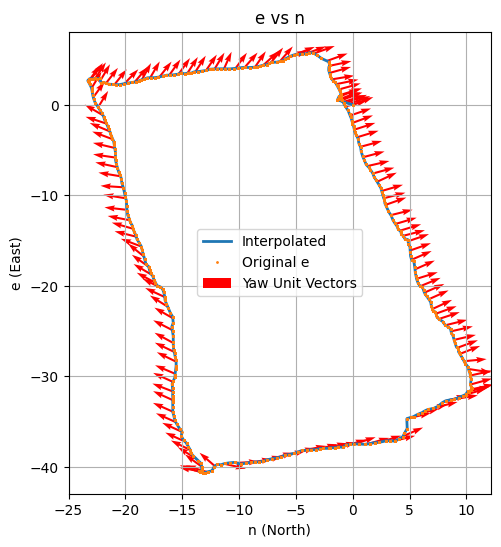

In [3]:

from pymap3d import geodetic2enu

# Example: GPS raw data: (N, 3) where each row is [lat, lon, alt]
# gps_raw_data = np.array([[lat1, lon1, alt1], [lat2, lon2, alt2], ..., [latN, lonN, altN]])

lat0, lon0, alt0, NedNorthVel0, NedEastVel0  = sensorData.gps_raw_data[0]  # Origin for ENU conversion

# Initialize arrays to store ENU coordinates
e = np.zeros(sensorData.gps_raw_data.shape[0])  # East
n = np.zeros(sensorData.gps_raw_data.shape[0])  # North
u = np.zeros(sensorData.gps_raw_data.shape[0])  # Up

# Convert each GPS point (lat, lon, alt) to ENU
for i, (lat, lon, alt, nedNorthVel, nedEastVel) in enumerate(sensorData.gps_raw_data):
    e[i], n[i], u[i] = geodetic2enu(lat, lon, alt, lat0, lon0, alt0)

gps_unique_timestamps_in_seconds = np.unique(sensorData.gps_timestamps_in_seconds)

# Stack the results into a single (N, 3) array for ENU positions
# Interpolation
interpolated_e = np.interp(sensorData.timestamps_in_seconds, sensorData.gps_timestamps_in_seconds, e)
interpolated_n = np.interp(sensorData.timestamps_in_seconds, sensorData.gps_timestamps_in_seconds, n)


# Angles are defined as follows
angles = np.array([roll_kf, pitch_kf, yaw_kf])  # roll, pitch, yaw
angles = np.transpose(angles)
# Assume yaw_kf is in radians
yaw_unit_x = np.cos(yaw_kf)
yaw_unit_y = np.sin(yaw_kf)

# Every 20th index
idx = np.arange(0, len(interpolated_e), 20)



# Plotting
plt.figure(figsize=(12, 6))

# Plot e vs n
plt.subplot(1, 2, 1)
plt.plot(interpolated_e, interpolated_n, '-', label='Interpolated', linewidth=2)
plt.plot(e, n, 'o', label='Original e', markersize=1)

# Plot unit yaw vectors as quivers
plt.quiver(interpolated_e[idx], interpolated_n[idx], 
           yaw_unit_x[idx], yaw_unit_y[idx], 
           angles='xy', scale_units='xy', color='r', label='Yaw Unit Vectors', scale=0.5)

plt.title('e vs n')
plt.xlabel('n (North)')
plt.ylabel('e (East)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from vpython import canvas, vector, arrow, color, curve
from scipy.spatial.transform import Rotation as R

# Setup the scene
scene = canvas(title='3D Trajectory with Local Frames (VPython)',
               width=1200, height=800, center=vector(0, 0, 0),
               background=color.white)

# Convert to VPython-friendly coordinates:
# VPython uses x=Right (East), y=Up, z=Backward (North is -z)
interpolated_u = np.interp(sensorData.timestamps_in_seconds, sensorData.gps_timestamps_in_seconds, u)
idx = np.arange(0, len(interpolated_e), 20)

# Plot trajectory line
traj = curve(color=color.black, radius=0.3)
for i in range(len(interpolated_e)):
    x = interpolated_e[i]
    y = interpolated_u[i]
    z = -interpolated_n[i]  # Flip North for VPython z-axis
    traj.append(pos=vector(x, y, z))

# Plot local axes
scale = 2  # axis length
for i in idx:
    r = R.from_euler('xyz', angles[i])
    rot_matrix = r.as_matrix()

    pos = vector(interpolated_e[i],
                 interpolated_u[i],
                 -interpolated_n[i])  # VPython uses -Z for North
    
    # X axis (forward) - Red
    x_axis = vector(*rot_matrix[:, 0]) * scale
    arrow(pos=pos, axis=x_axis, color=color.red, shaftwidth=0.2)

    # Y axis (left) - Green
    y_axis = vector(*rot_matrix[:, 1]) * scale
    arrow(pos=pos, axis=y_axis, color=color.green, shaftwidth=0.2)

    # Z axis (up) - Blue
    z_axis = vector(*rot_matrix[:, 2]) * scale
    arrow(pos=pos, axis=z_axis, color=color.blue, shaftwidth=0.2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import plotly.graph_objects as go
from scipy.spatial.transform import Rotation as R

# Interpolated positions
interpolated_u = np.interp(sensorData.timestamps_in_seconds, sensorData.gps_timestamps_in_seconds, u)
idx = np.arange(0, len(interpolated_e), 20)

# Compute local axes from RPY angles
unit_x = np.zeros((len(idx), 3))
unit_y = np.zeros((len(idx), 3))
unit_z = np.zeros((len(idx), 3))

for j, i in enumerate(idx):
    r = R.from_euler('xyz', angles[i])  # roll, pitch, yaw in radians
    rot_matrix = r.as_matrix()
    unit_x[j] = rot_matrix[:, 0]  # Forward
    unit_y[j] = rot_matrix[:, 1]  # Left
    unit_z[j] = rot_matrix[:, 2]  # Up

# Extract positions for quivers
e_pos = interpolated_e[idx]
n_pos = interpolated_n[idx]
u_pos = interpolated_u[idx]
scale = 2.0  # arrow length

fig = go.Figure()

# Trajectory line
fig.add_trace(go.Scatter3d(
    x=interpolated_e, y=interpolated_n, z=interpolated_u,
    mode='lines', name='Interpolated Trajectory',
    line=dict(color='black', width=4)
))

# Add cones for X (Forward, red)
fig.add_trace(go.Cone(
    x=e_pos, y=n_pos, z=u_pos,
    u=unit_x[:, 0]*scale, v=unit_x[:, 1]*scale, w=unit_x[:, 2]*scale,
    colorscale=[[0, 'red'], [1, 'red']], sizemode="absolute", sizeref=1,
    showscale=False, name="X (Forward)"
))

# Add cones for Y (Left, green)
fig.add_trace(go.Cone(
    x=e_pos, y=n_pos, z=u_pos,
    u=unit_y[:, 0]*scale, v=unit_y[:, 1]*scale, w=unit_y[:, 2]*scale,
    colorscale=[[0, 'green'], [1, 'green']], sizemode="absolute", sizeref=1,
    showscale=False, name="Y (Left)"
))

# Add cones for Z (Up, blue)
fig.add_trace(go.Cone(
    x=e_pos, y=n_pos, z=u_pos,
    u=unit_z[:, 0]*scale, v=unit_z[:, 1]*scale, w=unit_z[:, 2]*scale,
    colorscale=[[0, 'blue'], [1, 'blue']], sizemode="absolute", sizeref=1,
    showscale=False, name="Z (Up)"
))

# Layout settings
fig.update_layout(
    title='Interactive 3D Trajectory with Local Frames',
    scene=dict(
        xaxis_title='East (m)',
        yaxis_title='North (m)',
        zaxis_title='Up (m)',
        aspectmode='data'
    ),
    showlegend=False,
    height=800
)

fig.show()